In [1]:
import pandas as pd
import process_data

# Preprocess data skaters

In [2]:
# list of seasons to consider
# year_list = ['20142015', '20152016', '20162017', '20172018', '20182019', '20192020', '20202021', '20212022', '20222023', '20232024']
year_list = ['20202021', '20212022', '20222023', '20232024']

In [3]:
# find list of teams active between 2014 and 2024
team_id_list = []
for season in year_list:
    for id in process_data.get_season_teams(season):
        if id not in team_id_list:
            team_id_list.append(id)
team_id_list

['EDM',
 'BOS',
 'TOR',
 'COL',
 'CHI',
 'WPG',
 'PIT',
 'VGK',
 'FLA',
 'STL',
 'NYR',
 'CAR',
 'WSH',
 'MIN',
 'DAL',
 'LAK',
 'VAN',
 'SJS',
 'CGY',
 'TBL',
 'NYI',
 'MTL',
 'CBJ',
 'ARI',
 'PHI',
 'BUF',
 'DET',
 'OTT',
 'NJD',
 'ANA',
 'NSH',
 'SEA']

In [4]:
len(team_id_list)

32

In [5]:
# find list of player ids for players who played a game between 2010 and 2020
player_id_list = []
for team in team_id_list:
    for season in year_list:
        for id in process_data.get_all_player_ids(season, team):
            if id not in player_id_list:
                player_id_list.append(id)
player_id_list

[8471707,
 8471729,
 8474068,
 8474589,
 8475163,
 8475178,
 8475179,
 8475197,
 8476326,
 8476454,
 8476457,
 8476886,
 8476913,
 8476915,
 8477498,
 8477934,
 8478021,
 8478402,
 8478451,
 8478452,
 8479344,
 8479466,
 8479977,
 8480802,
 8480803,
 8480946,
 8481638,
 8481813,
 8470281,
 8473544,
 8474089,
 8474098,
 8475169,
 8475786,
 8476495,
 8476879,
 8476967,
 8477943,
 8477998,
 8478442,
 8478585,
 8479338,
 8479347,
 8480041,
 8481598,
 8474218,
 8475218,
 8475760,
 8476850,
 8477406,
 8479576,
 8480011,
 8480468,
 8482077,
 8470621,
 8474040,
 8474641,
 8475842,
 8477015,
 8477454,
 8479442,
 8480274,
 8481534,
 8470638,
 8471276,
 8473419,
 8474000,
 8475186,
 8475225,
 8475735,
 8475745,
 8475780,
 8475791,
 8475797,
 8476191,
 8476374,
 8476422,
 8476891,
 8477320,
 8477365,
 8477508,
 8477941,
 8477956,
 8478075,
 8478131,
 8478415,
 8478443,
 8478468,
 8478485,
 8478498,
 8478888,
 8479325,
 8479365,
 8479546,
 8480001,
 8480021,
 8480901,
 8480944,
 8482072,
 8473422,


In [6]:
len(player_id_list)

1351

In [7]:
# extract data about all players who played between 2010 and 2020, including personal data and stats from every season in the NHL during that period
player_stats = []
for player_id in player_id_list:
    try:
        pl_class = process_data.load_player(player_id, year_list)
        player_stats.append(pl_class)
    except Exception as e:
        print(e)
        continue

In [8]:
# total number of players extracted
len(player_stats)

1351

# Clean data

In [9]:
# restrict to players who played at least 3 seasons and 100 total games
reduced_player_stats = []
for temp in player_stats:
    games = 0
    years = 0
    for year in year_list:
        if year in temp.seasons.keys():
            games += temp.seasons[year].n_games_played
            years += 1
    if years >= 3 and games > 100:
        reduced_player_stats.append(temp)

In [10]:
# number of players with at least 3 seasons and 100 games
len(reduced_player_stats)

649

In [11]:
# create data for prediction, with every possible set of 2 consecutive seasons to predict the 3rd one
split_data = []
for player in reduced_player_stats:
    for i in range(len(year_list) - 2):
        years = year_list[i:i+3]
        if years[2] in player.seasons.keys():
            data = {'name': player.name,
                    'role': player.role,
                    'country': player.country,
                    'age': player.age,
                    'id': player.id,
                    'height': player.height,
                    'weight': player.weight
                    }
            data = {**data, **process_data.get_year_data_skaters(player, years[0], '1'), **process_data.get_year_data_skaters(player, years[1], '2')}
            data['season_1'] = years[0]
            data['season_2'] = years[1]
            data['season_3'] = years[2]
            data['ppg_3'] = player.get_ratio_season_points(years[2])
            split_data.append(data)

In [12]:
# transform the data into a pandas dtaframe for processing
df = pd.DataFrame(split_data)
df

,name,role,country,age,id,height,weight,goals_1,assists_1,pim_1,...,pim_2,games_2,shots_2,time_2,plus_minus_2,team_2,season_1,season_2,season_3,ppg_3
0,Alex Chiasson,A,CAN,34,8475163,193,94,9,7,33,...,24,67,98,11:37,4,Canucks,20202021,20212022,20222023,0.750000
1,Zack Kassian,A,CAN,33,8475178,191,96,2,3,15,...,63,58,58,11:47,2,Oilers,20202021,20212022,20222023,0.078431
2,Dmitry Kulikov,D,RUS,34,8475179,185,96,0,2,26,...,39,80,74,18:12,23,Wild,20202021,20212022,20222023,0.344262
3,Dmitry Kulikov,D,RUS,34,8475179,185,96,7,17,39,...,30,61,80,20:13,-11,Ducks,20212022,20222023,20232024,0.289474
4,Tyson Barrie,D,CAN,33,8475197,180,89,8,40,10,...,18,73,149,18:58,3,Oilers,20202021,20212022,20222023,1.032787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,Tommy Novak,A,USA,27,8478438,185,81,1,6,2,...,8,51,93,14:39,5,Predators,20212022,20222023,20232024,0.887324
1256,Philip Tomasino,A,CAN,23,8481577,183,81,0,0,0,...,10,76,111,11:32,2,Predators,20202021,20212022,20222023,0.741935
1257,Philip Tomasino,A,CAN,23,8481577,183,81,11,21,10,...,6,31,54,15:36,5,Predators,20212022,20222023,20232024,0.658537
1258,Matty Beniers,A,USA,22,8482665,188,82,0,0,0,...,0,10,18,16:56,-1,Kraken,20202021,20212022,20222023,1.012500


In [13]:
df = process_data.process_data_skaters(df)

In [14]:
# select only relevant columns
df_final = df[['games_1', 'games_2', 'goals_1', 'goals_2',
               'height', 'pim_1',
               'pim_2', 'plus_minus_1', 'plus_minus_2', 'role',
               'ppg_3', 'shots_1', 'shots_2', 'time_1',
               'time_2', 'weight', 'points_1', 'points_2', 'age']]

In [15]:
# transform position columns into one-hot encoded features
df_final = pd.get_dummies(df_final, columns=['role'])

In [16]:
# restrict to lines with some games played in one of the two seasons at least
df_final = df_final[(df_final['games_1']!=0)|(df_final['games_2']!=0)]

In [17]:
# replace NaN by zero because they come from seasons where the player did not play
df_final = df_final.fillna(0)

In [18]:
df_final

,games_1,games_2,goals_1,goals_2,height,pim_1,pim_2,plus_minus_1,plus_minus_2,ppg_3,shots_1,shots_2,time_1,time_2,weight,points_1,points_2,age,role_A,role_D
0,0.548780,0.817073,0.200000,0.194030,193,0.733333,0.358209,-10,4,0.750000,1.444444,1.462687,0.266667,0.164179,94,0.355556,0.328358,34,True,False
1,0.329268,0.707317,0.074074,0.103448,191,0.555556,1.086207,-4,2,0.078431,0.666667,1.000000,0.407407,0.189655,96,0.185185,0.327586,33,True,False
2,0.463415,0.975610,0.000000,0.087500,185,0.684211,0.487500,-4,23,0.344262,1.131579,0.925000,0.500000,0.225000,96,0.052632,0.300000,34,False,True
3,0.975610,0.743902,0.087500,0.049180,185,0.487500,0.491803,23,-11,0.289474,0.925000,1.311475,0.225000,0.327869,96,0.300000,0.245902,34,False,True
4,0.682927,0.890244,0.142857,0.095890,180,0.178571,0.246575,4,3,1.032787,2.607143,2.041096,0.375000,0.246575,89,0.857143,0.561644,33,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,0.329268,0.621951,0.037037,0.333333,185,0.074074,0.156863,-4,5,0.887324,0.925926,1.823529,0.407407,0.274510,81,0.259259,0.843137,27,True,False
1256,0.000000,0.926829,0.000000,0.144737,183,0.000000,0.131579,0,2,0.741935,0.000000,1.460526,0.000000,0.144737,81,0.000000,0.421053,23,True,False
1257,0.926829,0.378049,0.144737,0.161290,183,0.131579,0.193548,2,5,0.658537,1.460526,1.741935,0.144737,0.483871,81,0.421053,0.580645,23,True,False
1258,0.000000,0.121951,0.000000,0.300000,188,0.000000,0.000000,0,-1,1.012500,0.000000,1.800000,0.000000,1.600000,82,0.000000,0.900000,22,True,False


# Predict points per game

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [20]:
# split label column from the features
X = df_final.drop(['ppg_3'], axis=1)
y = df_final['ppg_3']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [21]:
print('Number of training data:', len(X_train))
print('Number of testing data:', len(X_test))

Number of training data: 1071
Number of testing data: 189


In [22]:
# find mean and std of columns that were not normalized by the number of games
standardization = {}
for col in ['height', 'weight', 'age', 'plus_minus_1', 'plus_minus_2', 'time_1', 'time_2']:
    mu = X_train[col].mean()
    sig = X_train[col].std()
    standardization[col] = {'mu': mu, 'sig': sig}

standardization

{'height': {'mu': 186.38095238095238, 'sig': 5.593936255485987},
 'weight': {'mu': 91.50140056022408, 'sig': 6.7556655281464755},
 'age': {'mu': 29.398692810457515, 'sig': 4.00008857027346},
 'plus_minus_1': {'mu': 0.8057889822595705, 'sig': 12.407926472765737},
 'plus_minus_2': {'mu': 0.37254901960784315, 'sig': 14.401205587551733},
 'time_1': {'mu': 0.5384684790145441, 'sig': 1.1720201482944819},
 'time_2': {'mu': 0.3770461428508241, 'sig': 0.6748691041191553}}

In [23]:
# function to normalize the data
def normalize_data(data):
    for col in ['height', 'weight', 'age', 'plus_minus_1', 'plus_minus_2', 'time_1', 'time_2']:
        data[col] = (data[col] - standardization[col]['mu']) / standardization[col]['sig']
    return data

In [24]:
# normalize the data 
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

In [25]:
# use last season's points as benchmark prediction
print('RMSE:', root_mean_squared_error(X_test['points_2'], y_test))

RMSE: 0.29492853145680326


In [26]:
# train a linear regression model and evaluate on test data
model = LinearRegression().fit(X_train, y_train)

print('RMSE:', root_mean_squared_error(model.predict(X_test), y_test))

RMSE: 0.23814179536991184


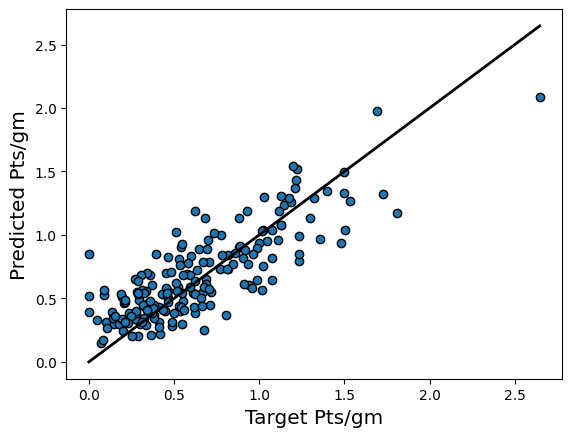

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, model.predict(X_test), edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Pts/gm', size='x-large')
ax.set_ylabel('Predicted Pts/gm', size='x-large')
plt.savefig('plot.png')

In [28]:
# extract data for the last two seasons to predict the new one
pred_data = []
for player in player_stats:
        years = ['20222023', '20232024', '20242025']
        data = {'name': player.name,
                'role': player.role,
                'country': player.country,
                'age': player.age,
                'id': player.id,
                'height': player.height,
                'weight': player.weight
                }
        data = {**data, **process_data.get_year_data_skaters(player, years[0], '1'), **process_data.get_year_data_skaters(player, years[1], '2')}
        data['season_1'] = years[0]
        data['season_2'] = years[1]
        data['season_3'] = years[2]
        pred_data.append(data)

In [29]:
df_pred = pd.DataFrame(pred_data)
df_pred

,name,role,country,age,id,height,weight,goals_1,assists_1,pim_1,...,assists_2,pim_2,games_2,shots_2,time_2,plus_minus_2,team_2,season_1,season_2,season_3
0,James Neal,A,CAN,37,8471707,191,96,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
1,Kris Russell,D,CAN,37,8471729,178,77,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
2,Kyle Turris,A,CAN,35,8474068,185,86,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
3,Tyler Ennis,A,CAN,35,8474589,175,73,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
4,Alex Chiasson,A,CAN,34,8475163,193,94,6,3,6,...,0,0,0,0,0,0,0,20222023,20232024,20242025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,Shane Wright,A,CAN,20,8483524,183,87,1,1,2,...,1,0,8,12,13:32,1,Kraken,20222023,20232024,20242025
1347,Tye Kartye,A,CAN,23,8481789,180,92,3,2,2,...,9,37,77,109,11:50,-1,Kraken,20222023,20232024,20242025
1348,Ryan Winterton,A,CAN,21,8482751,188,79,0,0,0,...,0,0,9,10,9:20,-1,Kraken,20222023,20232024,20242025
1349,Ryker Evans,D,CAN,22,8482858,183,88,0,0,0,...,8,20,36,44,19:11,-5,Kraken,20222023,20232024,20242025


In [30]:
df_pred = process_data.process_data_skaters(df_pred)
df_pred = df_pred[df_pred['role']!='N/A']

In [31]:
df_pred_final = df_pred[['name', 'games_1', 'games_2', 'goals_1', 'goals_2',
               'height', 'pim_1',
               'pim_2', 'plus_minus_1', 'plus_minus_2', 'role',
               'shots_1', 'shots_2', 'time_1',
               'time_2', 'weight', 'points_1', 'points_2', 'age']]

df_pred_final = df_pred_final.fillna(0)
df_pred_final = pd.get_dummies(df_pred_final, columns=['role'])

df_pred_final = normalize_data(df_pred_final)

In [32]:
predictions = df_pred_final[['name']]
predictions['first name'] = predictions['name'].apply(lambda s: s.split(' ')[0])
predictions['last name'] = predictions['name'].apply(lambda s: s.split(' ')[1])
predictions['ppg'] = model.predict(df_pred_final.drop('name', axis=1))
predictions = predictions.groupby(['name', 'first name', 'last name']).max().reset_index()

C:\Users\guill\AppData\Local\Temp\ipykernel_32500\1632674256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['first name'] = predictions['name'].apply(lambda s: s.split(' ')[0])
C:\Users\guill\AppData\Local\Temp\ipykernel_32500\1632674256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['last name'] = predictions['name'].apply(lambda s: s.split(' ')[1])
C:\Users\guill\AppData\Local\Temp\ipykernel_32500\1632674256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

In [33]:
predictions = predictions.sort_values('ppg', ascending=False)
predictions

,name,first name,last name,ppg
936,Nathan MacKinnon,Nathan,MacKinnon,2.247993
289,Connor McDavid,Connor,McDavid,2.184414
975,Nikita Kucherov,Nikita,Kucherov,2.038250
328,David Pastrnak,David,Pastrnak,1.894723
117,Auston Matthews,Auston,Matthews,1.839619
...,...,...,...,...
368,Duncan Keith,Duncan,Keith,-0.084871
596,Joe Thornton,Joe,Thornton,-0.106277
84,Andy Greene,Andy,Greene,-0.108107
1028,Patrick Marleau,Patrick,Marleau,-0.115963


In [34]:
final_player_list = []
for player_name in predictions['name'].unique():
    for player in reduced_player_stats:
        if player.name == player_name:
            player.predict_points = predictions.loc[predictions['name']==player_name]['ppg'].item()
            final_player_list.append(player)

# Branch-and-Bound Algorithm to choose the best pool team

In [35]:
from pool_classifier import solve_problem

In [37]:
# algo
selected_players, total_ppg, total_salary = solve_problem(final_player_list)
print("Selected Players:", selected_players)
print("Total PPG:", total_ppg)
print("Total Salary (Millions):", total_salary)
pd.DataFrame(selected_players, columns=['name']).to_csv('meilleure_solution.csv')

Selected Players: ['Nathan MacKinnon', 'Connor McDavid', 'Nikita Kucherov', 'Jack Hughes', 'Cale Makar', 'Carter Verhaeghe', 'Kirby Dach', 'Patrick Kane', 'Viktor Arvidsson', 'Shea Theodore', 'Evan Bouchard', 'Noah Dobson', 'Jack Quinn', 'Mason McTavish', 'Daniel Sprong', 'JJ Peterka', 'Shayne Gostisbehere', 'Adam Boqvist']
Total PPG: 23.17002928235992
Total Salary (Millions): 87792500
